In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline

In [2]:
IMG_SHAPE = 128
BATCH_SIZE = 64
EPOCHS = 50

In [3]:
def load_dataset():
    X = []
    y = []
    for path in glob.glob('normaltrucks/*.jpg'):
        img = tf.keras.preprocessing.image.load_img(path)
        img = tf.keras.preprocessing.image.smart_resize(tf.keras.preprocessing.image.img_to_array(img)/255.0,(IMG_SHAPE,IMG_SHAPE))
        X.append(img)
        y.append([0])
    for path in glob.glob('overtrucks/*.jpg'):
        img = tf.keras.preprocessing.image.load_img(path)
        img = tf.keras.preprocessing.image.smart_resize(tf.keras.preprocessing.image.img_to_array(img)/255.0,(IMG_SHAPE,IMG_SHAPE))
        X.append(img)
        y.append([1])
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [4]:
X, y = load_dataset()
X.shape, y.shape

((147, 128, 128, 3), (147, 1))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape

((117, 128, 128, 3), (117, 1))

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.applications.MobileNet(include_top=False, weights='imagenet'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, None, None, 1024)  3228864  
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,277,569
Trainable params: 4,255,681
Non-trainable params: 21,888
_________________________________________________________________


In [7]:
hist = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, validation_batch_size=8, shuffle=True)

Epoch 1/50
2/2 [==============================] - 14s 4s/step - loss: 1.0186 - accuracy: 0.5269 - val_loss: 0.2780 - val_accuracy: 0.8750
Epoch 2/50
2/2 [==============================] - 6s 2s/step - loss: 0.0187 - accuracy: 1.0000 - val_loss: 0.4949 - val_accuracy: 0.7083
Epoch 3/50
2/2 [==============================] - 6s 2s/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.7035 - val_accuracy: 0.6667
Epoch 4/50
2/2 [==============================] - 6s 2s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.8106 - val_accuracy: 0.6667
Epoch 5/50
2/2 [==============================] - 6s 2s/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.8604 - val_accuracy: 0.7083
Epoch 6/50
2/2 [==============================] - 6s 2s/step - loss: 6.1196e-04 - accuracy: 1.0000 - val_loss: 0.8697 - val_accuracy: 0.6667
Epoch 7/50
2/2 [==============================] - 6s 2s/step - loss: 3.3744e-04 - accuracy: 1.0000 - val_loss: 0.8658 - val_accuracy: 0.6667
Epoch 8/50
2/2 [================

In [8]:
def predict(path):
    img = tf.keras.preprocessing.image.load_img(path)
    img = tf.keras.preprocessing.image.smart_resize(tf.keras.preprocessing.image.img_to_array(img)/255.0,(IMG_SHAPE,IMG_SHAPE))
    pred = model.predict(np.array([img]))[0]
    plt.imshow(img)
    if (pred >= 0.6):
        plt.title('Truck is overloaded')
    elif (pred > 0.4) and (pred < 0.6):
        plt.title("Not Sure")
    else:
        plt.title("Truck is not Overloaded")
    plt.show()
    if(pred>=0.6):
        return True

In [9]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 0.2434 - accuracy: 0.9000


[0.2433774769306183, 0.8999999761581421]

1/1 [==============================] - 1s 1s/step


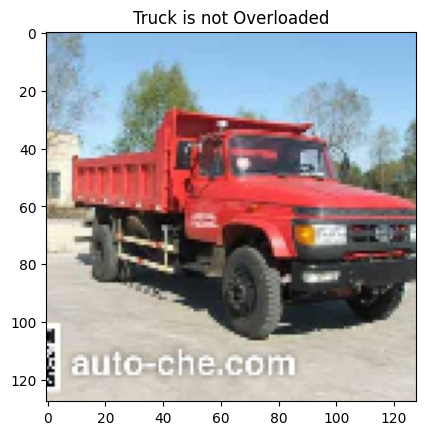

In [10]:
predict('normaltrucks/08-NT.jpg')

1/1 [==============================] - 0s 89ms/step


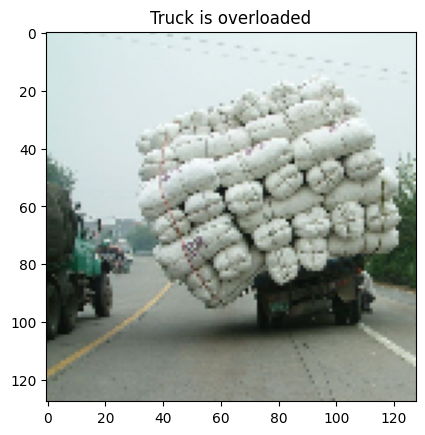

True

In [11]:
predict('overtrucks/02-OT.jpg')

1/1 [==============================] - 0s 150ms/step


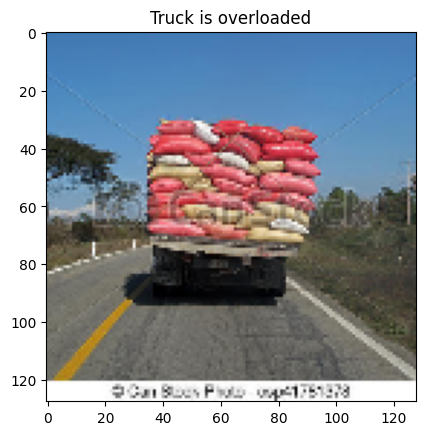

True

In [26]:
predict('overtrucks/68-OT.jpg')

In [ ]:
predict('overtrucks/84-OT.jpg')

In [20]:
import cv2
import sqlite3
from tabulate import tabulate
import scanner
import datetime

cam=cv2.VideoCapture(0)
cv2.namedWindow("WebCam")
img_counter=0
while True:
    ret,frame=cam.read()
    if not ret:
        print("Failed to grab frame")
        break
    cv2.imshow("WebCam",frame)

    k = cv2.waitKey(1)
    if k%256==27:
        # ESC pressed
        print("Closing...")
        break

    elif k%256==32:
        # SPACE pressed
        img_name="opencv_frame_{}.jpg".format(img_counter)
        cv2.imwrite(img_name,frame)
        if(predict(img_name)):

            conn=sqlite3.connect('Magnusa.db')
            cur=conn.cursor()

            cur.execute("Select mapper_class from Vehicleclass") 
            result=cur.fetchall()
            fastag_data=scanner.decoder()
            tag=fastag_data.split(',')[0]
            fine=500
            cur.execute("Insert into Fine(fastag_id) values (?)",(tag,))
            conn.commit()
            cur.execute("SELECT EXISTS(SELECT 1 FROM Fine WHERE fastag_id=?)",(tag,))
            myresult=cur.fetchall()
            conn.commit()
            cur.close()

    #print("{} written!".format(img_name))
    img_counter+=1

cam.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter.filedialog import askopenfile
from PIL import Image, ImageTk
my_w = tk.Tk()
my_w.geometry("430x500")
my_w.title('Prototype')
my_font1=('times', 18, 'bold')
l1 = tk.Label(my_w,text='Add any photo of a commercial vehicle',width=30,font=my_font1)  
l1.grid(row=1,column=1)
b1 = tk.Button(my_w, text='Upload File', 
   width=20,command = lambda:upload_file())
b1.grid(row=2,column=1) 

def upload_file():
    global img, path
    f_types = [('testing', '*.jpg')]
    filename = filedialog.askopenfilename(filetypes=f_types)
    img = ImageTk.PhotoImage(file=filename)
    #path = filedialog.askopenfilename(initialdir=os.getcwd())
    predict(filename)
    b2 =tk.Button(my_w,image=img)
    b2.grid(row=3,column=1)

my_w.mainloop()

In [1]:
import sqlite3
from tabulate import tabulate
import scanner
import datetime

conn=sqlite3.connect('Magnusa.db')
cur=conn.cursor()

cur.execute("Select mapper_class from Vehicleclass") 
result=cur.fetchall()
fastag_data=scanner.decoder()
tag=fastag_data.split(',')[0]
fine=500
cur.execute("Insert into Fine(fastag_id) values (?)",(tag,))
conn.commit()
cur.execute("SELECT EXISTS(SELECT 1 FROM Fine WHERE fastag_id=?)",(tag,))
myresult=cur.fetchall()
conn.commit()
cur.close()

Barcode: 300,VC16,LMV,WB56B4211 | Type: QRCODE


In [ ]:

import cv2

import sqlite3
from tabulate import tabulate
import scanner
import datetime

conn=sqlite3.connect('Magnusa.db')
cur=conn.cursor()

#cur.execute("Select mapper_class from Vehicleclass") 
#result=cur.fetchall()
fastag_data=scanner.decoder()
tag=fastag_data.split(',')[0]
#tag='100'
vc=fastag_data.split(',')[1]
regno=fastag_data.split(',')[3]
# fine=500
# cur.execute("Insert into Fine(fastag_id) values (?)",(tag,))
# conn.commit()
cur.execute("SELECT EXISTS(SELECT 1 FROM Fastag WHERE fastag_id=?)",(tag,))
fasttag_query=cur.fetchall()
if(fasttag_query[0]==(0,)):
    cur.execute("Insert into Fastag(fastag_id, vehicle_class, registration_no) values (?,?,?)",(tag,vc,regno))
    conn.commit()

#Vechicle class axle check goes here 


# cur.execute("Insert into Fine(fastag_id) values (?)",(tag,))
# conn.commit()

cur.execute("SELECT EXISTS(SELECT 1 FROM Fine WHERE fastag_id=?)",(tag,))
myresult=cur.fetchall()
if(myresult[0]==(1,)):
    cur.execute("SELECT Date FROM Fine WHERE fastag_id = ?", (tag,))
    dateresult=cur.fetchall()
    print(dateresult)
    if(dateresult[0]==(None,)):
        
        #Deduct toll+fine
        #Display total toll in front end
        finedate=datetime.datetime.now()
        date=int(finedate.strftime("%Y%m%d%H%M%S"))
        print(1)
        cur.execute("Update Fine set Date=? Where fastag_id=?",(date,tag,))
        conn.commit()
    
    else:
        cur.execute("Select Date from Fine Where fastag_id=?",(tag,))
        dates=cur.fetchone()
        currentdate=datetime.datetime.now()
        date=int(currentdate.strftime("%Y%m%d%H%M%S"))
        #print(date)
        #print(dates)
        final_date = (date - dates[0])
        if(final_date<9000000):
            print("Deducting normal toll")
        #Usual toll
        else:
            print("deducting fine")
else:



    #sreeparno code
    
    cam=cv2.VideoCapture(0)
    cv2.namedWindow("WebCam")
    img_counter=0
    while True:
        ret,frame=cam.read()
        if not ret:
            print("Failed to grab frame")
            break
        cv2.imshow("WebCam",frame)

        k = cv2.waitKey(1)
        if k%256==27:
            # ESC pressed
            print("Closing...")
            break

        elif k%256==32:
            # SPACE pressed
            img_name="opencv_frame_{}.jpg".format(img_counter)
            cv2.imwrite(img_name,frame)
            if(predict(img_name)):







    #overload check
                fine=20000
                cur.execute("Insert into Fine(fastag_id,amount) values (?,?)",(tag,fine))
                conn.commit()
                pass
conn.commit()
cur.close()
#print(tabulate(result, headers=['mapper class']))

17002
(20000,)
12230
1/1 [==============================] - 0s 101ms/step


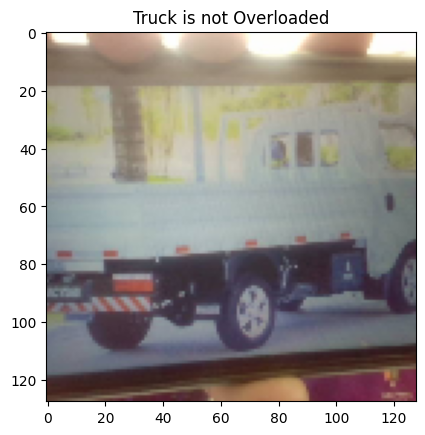

Closing...
(None,)


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:967: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [12]:
import sqlite3
from tabulate import tabulate
import scanner
import datetime
import cv2
import numpy as np
from pyzbar.pyzbar import decode
#import WeightValue
import testmail

# def weight():
#     curr_weight=WeightValue.weightSense()
#     cur.execute("Select gvwr from Vehicleclass where mapper_class=?" ,(vc,))
#     gvwr=cur.fetchall()
#     if (curr_weight/10)>gvwr[0]:
#         return (1)
#     else:
#         return 0

#def initialweight():
 #   cur.execute("Select gvwr from Vehicleclass where mapper_class=?", (vc,))
  #  gvwr=cur.fetchall()[0]
   # return gvwr[0]
    

def scaner():
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        cv2.imshow('Image', frame)
        code = cv2.waitKey(10)
        if code == ord('q'):
            break
        gray_img = cv2.cvtColor(frame,0)
        barcode = decode(gray_img)

        for obj in barcode:
            points = obj.polygon
            (x,y,w,h) = obj.rect
            pts = np.array(points, np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(frame, [pts], True, (0, 255, 0), 3)

            barcodeData = obj.data.decode("utf-8")
            barcodeType = obj.type
            string = "Data " + str(barcodeData) + " | Type " + str(barcodeType)
        
            cv2.putText(frame, string, (x,y), cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,0,0), 2)
            #print("Barcode: "+barcodeData +" | Type: "+barcodeType)
            return(barcodeData)

def addfine():
    fine=20000
    cur.execute("Insert into Fine(fastag_id,amount) values (?,?)",(tag,fine,))
    cur.execute("Select fine_count from Fastag Where fastag_id=?",(tag,))
    finecount=cur.fetchall()[0]
    print(finecount)
    if(finecount==(None,)):
        cur.execute("Update Fastag set fine_count=? Where fastag_id=?",(1,tag,))
        conn.commit()

    else:
        count=finecount[0]
        cur.execute("Update Fastag set fine_count=? Where fastag_id=?",(count+1,tag,))
        conn.commit()

        cur.execute("Select fine_count from Fastag where fastag_id=?", (tag,))
        olcount=cur.fetchall()[0]
        #print(olcount)
        if (olcount[0]>5):
            #Call email function
            testmail.mail(regno)
            pass
    conn.commit()


conn=sqlite3.connect('Magnusa.db')
cur=conn.cursor()
while True:
#cur.execute("Select mapper_class from Vehicleclass") 
#result=cur.fetchall()
    fastag_data=scaner()
    tag=fastag_data.split(',')[0]
    print(tag)
#tag='100'
    vc=fastag_data.split(',')[1]
    regno=fastag_data.split(',')[3]
# fine=500
# cur.execute("Insert into Fine(fastag_id) values (?)",(tag,))
# conn.commit()
    cur.execute("SELECT EXISTS(SELECT 1 FROM Fastag WHERE fastag_id=?)",(tag,))
    fasttag_query=cur.fetchall()
    if(fasttag_query[0]==(0,)):
        cur.execute("Insert into Fastag(fastag_id, vehicle_class, registration_no) values (?,?,?)",(tag,vc,regno))
        conn.commit()

#Vechicle class axle check goes here 


# cur.execute("Insert into Fine(fastag_id) values (?)",(tag,))
# conn.commit()

    cur.execute("SELECT EXISTS(SELECT 1 FROM Fine WHERE fastag_id=?)",(tag,))
    myresult=cur.fetchall()
    if(myresult[0]==(1,)):
        cur.execute("SELECT Date FROM Fine WHERE fastag_id = ?", (tag,))
        dateresult=cur.fetchall()
    #print(dateresult)
        if(dateresult[0]==(None,)):
            cur.execute("Select amount from Fine Where fastag_id=?", (tag,))
            fineamount=cur.fetchall()[0]
            print(fineamount)
        #Deduct toll+fine
        #Display total toll in front end
            finedate=datetime.datetime.now()
            date=int(finedate.strftime("%Y%m%d%H%M%S"))
        #print(1)
            cur.execute("Update Fine set Date=? Where fastag_id=?",(date,tag,))
            conn.commit()
    
        else:
            cur.execute("Select Date from Fine Where fastag_id=?",(tag,))
            dates=cur.fetchone()
            currentdate=datetime.datetime.now()
            date=int(currentdate.strftime("%Y%m%d%H%M%S"))
        #print(date)
        #print(dates)
            final_date = (date - dates[0])
            if(final_date<100): #9000000
                print("Deducting normal toll as 24hrs not passed")
        #Usual toll
            else:
            
                cur.execute("Delete from Fine Where fastag_id=?",(tag,))
                conn.commit()

                #Sreeparno's code
                
                cam=cv2.VideoCapture(0)
                cv2.namedWindow("WebCam")
                img_counter=0
                while True:
                    ret,frame=cam.read()
                    if not ret:
                        print("Failed to grab frame")
                        break
                    cv2.imshow("WebCam",frame)

                    k = cv2.waitKey(1)
                    if k%256==27:
                        # ESC pressed
                        print("Closing...")
                        break

                    elif k%256==32:
                        # SPACE pressed
                        img_name="opencv_frame_{}.jpg".format(img_counter)
                        cv2.imwrite(img_name,frame)
                        if(predict(img_name)):
                            #addfine()
                            value=1
                        else:
                            value=0
                f=open('Myfile.txt', 'r')
                curr_weight=float(f.read())
                
                cur.execute("Select gvwr from Vehicleclass where mapper_class=?", (vc,))
                gvwr_curr=cur.fetchall()[0]
                gvwr=gvwr_curr[0]
                if((curr_weight/10))>gvwr:
                    weightover=1
                else:
                    weightover=0
                
                if value==1 or weightover==1:
                    addfine()
#                 overload=weight()
#                 if overload==1 or value==1:
#                     addfine()
#                 else:
#                     print("Vehicle is not overload")
    else:
            #gvwr=initialweight()
            #print(gvwr)
            cam=cv2.VideoCapture(0)
            cv2.namedWindow("WebCam")
            img_counter=0
            while True:
                ret,frame=cam.read()
                if not ret:
                    print("Failed to grab frame")
                    break
                cv2.imshow("WebCam",frame)

                k = cv2.waitKey(1)
                if k%256==27:
                    # ESC pressed
                    print("Closing...")
                    break

                elif k%256==32:
                    # SPACE pressed
                    img_name="opencv_frame_{}.jpg".format(img_counter)
                    cv2.imwrite(img_name,frame)
                    if(predict(img_name)):
                        #addfine()
                            value=1
                    else:
                            value=0
            f=open('Myfile.txt', 'r')
            curr_weight=float(f.read())
                
            cur.execute("Select gvwr from Vehicleclass where mapper_class=?", (vc,))
            gvwr_curr=cur.fetchall()[0]
            gvwr=gvwr_curr[0]
            if((curr_weight/10))>gvwr:
                weightover=1
            else:
                weightover=0
                
            if value==1 or weightover==1:
                addfine()
#             overload=weight()
#             if overload==1 or value==1:
#                     addfine()
#             else:
#                     print("Vehicle is not overload")
        #     percentage=100*float(curr_weight)/float(gvwr)
        #     if percentage>10:
        #         #inform authorities
        #         pass
        # else:
        #     pass
            #print("Vehicle not overloaded")
   
    k = cv2.waitKey(1)
    if k%256==27:
        print("Closing...")
        break
    
    
    conn.commit()
    #cur.close()
#print(tabulate(result, headers=['mapper class']))